# Task: Build an autoencoder model to improve the clarity of dental X-rays (denoise the X-rays) using the dental panoramic dataset. 

Dataset: Dental-Panaromic-Autoencoder.npz

This dataset consists of anonymized and de-identified panoramic dental X-rays of 116 patients, taken at Noor Medical Imaging Center, Qom, Iran. The subjects cover a wide range of dental conditions from healthy, to partial, and complete edentulous cases. The mandibles of all cases are manually segmented by two dentists. The dataset is saved in compressed NumPy format which when loaded using numpy.load will give you x_train, y_train, x_test and y_test NumPy arrays respectively.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses, models
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model


2025-04-27 16:50:29.289987: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-27 16:50:29.290600: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-27 16:50:29.292912: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-27 16:50:29.298739: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745790629.308825    4655 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745790629.31

## Task A:
### Load the Dental-Panaromic-Autoencoder.npz dataset using NumPy.load. 
Note: NPZ is a file format by NumPy that provides storage of array data using gzip compression.

In [2]:
#Load the Dental-Panaromic-Autoencoder.npz dataset using NumPy.load. 
data = np.load('DENTAL~1.NPZ')

### Extract x_train, y_train, x_test and y_test numpy arrays from the dataset

In [3]:
x_train = data['x_train']
x_test = data['x_test']
y_test = data['y_test']
y_train = data['y_train']

### A noisy version of the dataset will be created by applying random noise to each image.
With a noise factor of 0.2, add noise to the signal by multiplying the noise factor and random values from a normal distribution. 

Hint: 
noise_factor = 0.2

x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 

x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

Clip the signal values between 0 and 1

In [4]:
#add noise With a noise factor of 0.2, add noise to the signal by multiplying the noise factor and random values from a normal distribution. 
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

In [5]:
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

### Plot the first 5 Xray images from original images (x_train)

<Figure size 1000x200 with 0 Axes>

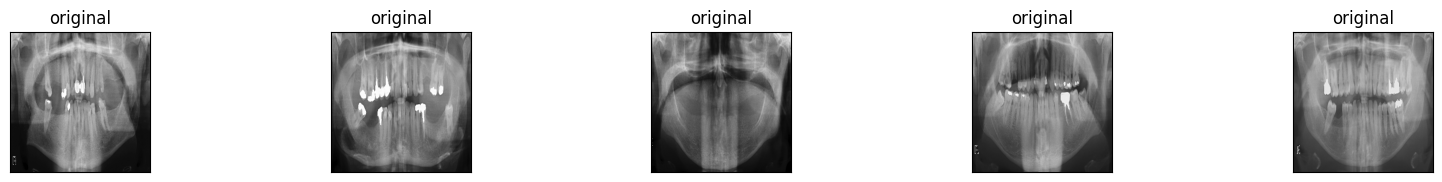

In [6]:
# Plot the first 5 images
plt.figure(figsize=(10, 2))
n = 5
plt.figure(figsize=(20, 4))
for i in range(n):
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_train[i])
  plt.title("original")
  plt.autumn()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

### Plot the first 5 Xray images from noise images (x_train_noisy)

<Figure size 1000x200 with 0 Axes>

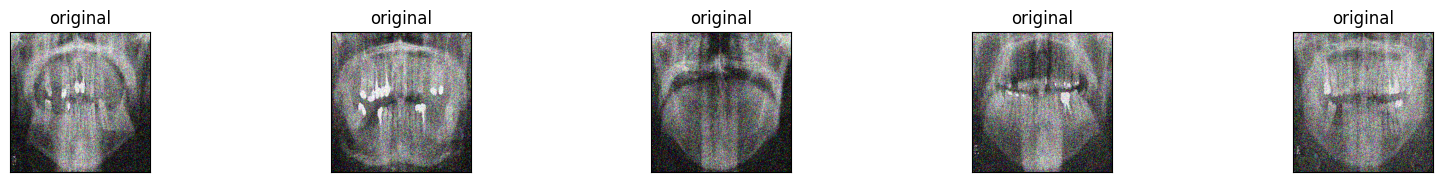

In [7]:
# Plot the first 5 images
plt.figure(figsize=(10, 2))
n = 5
plt.figure(figsize=(20, 4))
for i in range(n):
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_train_noisy[i])
  plt.title("original")
  plt.autumn()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

In [8]:
x_train_noisy = x_train_noisy.reshape((len(x_train_noisy), 256, 256, 3))
x_test_noisy = x_test_noisy.reshape((len(x_test_noisy), 256, 256, 3))
#Reshape the data to 256x256x3
x_train = x_train.reshape((len(x_train), 256, 256, 3))
x_test = x_test.reshape((len(x_test), 256, 256, 3))

### Train an autoencoder using the noisy image as the input and the original image as the destination. The images are shaped 256x256 in RGB scale

Create a Denoise class inherited from Keras Model 

The class has an encoder member variable of the following layers:

Input Layer of shape 256*256*3

Conv2D with 64 filters, kernel size 3,3, activation relu and same padding and strides 2

Conv2D with 32 filters, kernel size 3,3, activation relu and same padding and strides 2

The class has a decoder member variable of below layers

Conv2DTranspose with 32 filters, kernel size 3,3, activation relu and same padding and stride 2

In [9]:
class DenoiseModel(tf.keras.Model):
    def __init__(self):
        super(DenoiseModel, self).__init__()
        
        # Encoder layers
        self.encoder = models.Sequential([
            layers.Input(shape=(256, 256, 3)),  # Input Layer
            layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2),
        ])
        
        # Decoder layers
        self.decoder = models.Sequential([
            layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same', strides=2)  # Output layer
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

### Initialize the autoencoder object of the class Denoise
### Compile the autoencoder with Adam optimizer and MeanSquaredError as loss

In [10]:
autoencoder = DenoiseModel()
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError(), metrics=['mae'])

2025-04-27 16:50:31.541441: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


### Train the autoencoder with X as x_train_noisy and Y as x_train for 10 epochs and validation data as x_test_noisy and x_test

In [11]:
history = autoencoder.fit(x_train_noisy, x_train,epochs=50, validation_data=(x_test_noisy, x_test))

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step - loss: 0.0528 - mae: 0.1826 - val_loss: 0.0526 - val_mae: 0.1825
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.0510 - mae: 0.1799 - val_loss: 0.0523 - val_mae: 0.1821
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.0517 - mae: 0.1810 - val_loss: 0.0519 - val_mae: 0.1815
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.0522 - mae: 0.1825 - val_loss: 0.0512 - val_mae: 0.1803
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.0510 - mae: 0.1802 - val_loss: 0.0501 - val_mae: 0.1785
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.0512 - mae: 0.1808 - val_loss: 0.0483 - val_mae: 0.1751
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.0481 - mae: 0.1751 - val_loss: 0.0457 - val_mae: 0.1705
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.0455 - mae: 0.1698 - val_loss: 0.0417 - val_mae: 0.1616
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.0403 - mae: 

### Plot training and validation MAE and loss against epochs

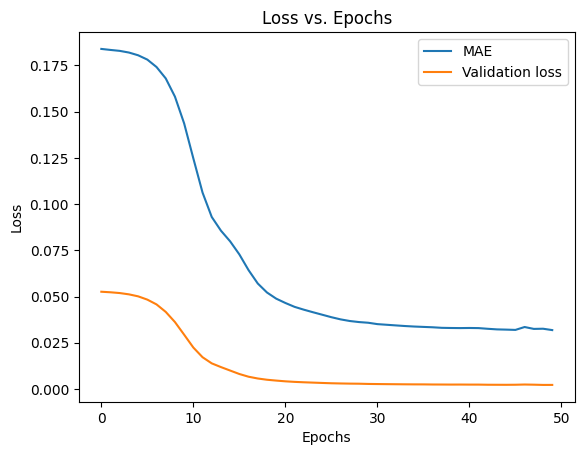

In [12]:
plt.plot(history.history['mae'], label='MAE')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Observation
- MAE and Validation loss are both steadily decreasing 
- Early stopping could have been employeed as the plot appears to plateau

## Task B:
### Evaluate the autoencoder model on x_test
Pass the x_test into the encoder

Pass the encoded images into the decoder. This step gives the decoded images that are reconstructed from the original.

Plot both the first 10 noisy images (x_test_noisy) and images without noise produced by the autoencoder.  Check how well the AutoEncoder model has done the job with denoising.

In [13]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

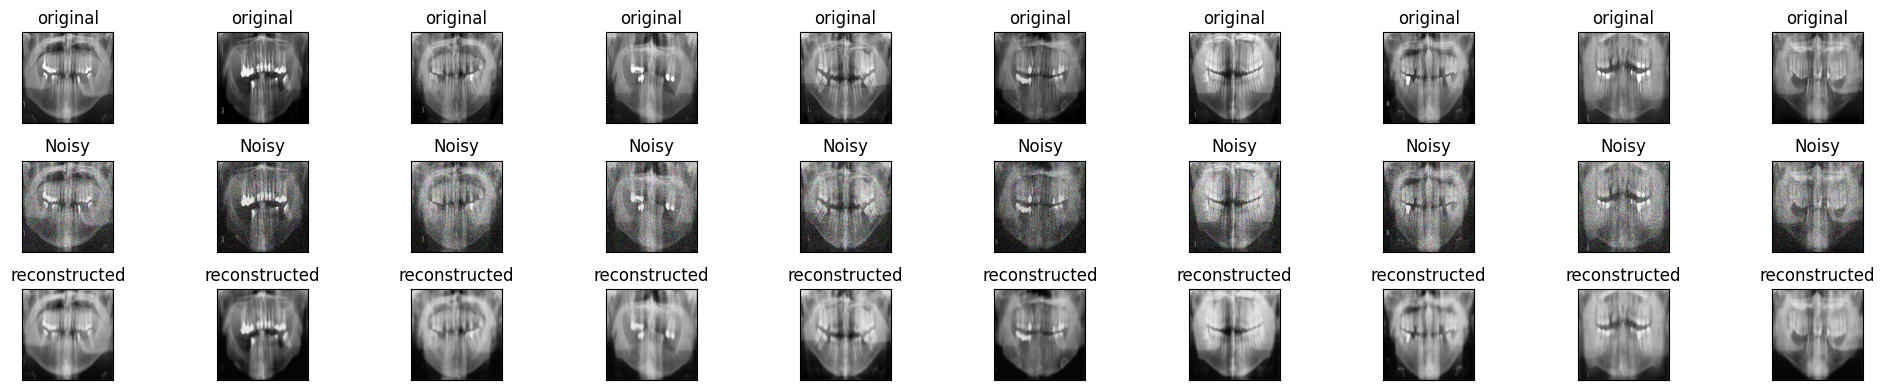

In [14]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  ax = plt.subplot(3, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(3, n, i + 1+n)
  plt.imshow(x_test_noisy[i])
  plt.title("Noisy")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(3, n, i + 1 + 2* n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()

#### Observation
- Autoencoder did a good job at reconstructing the image based off the noisy data, approximating the original image pretty well.